In [457]:
import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('p4clean.csv')

In [157]:
df["JOB_SEARCH"] = df["JOB_SEARCH"].fillna(0)
X = df.drop(["PUBID", "JOB_SEARCH"], axis = 1)
X = X.fillna(-999)
y = df["JOB_SEARCH"].astype("int64")

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [341]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
f2 = make_scorer(fbeta_score, beta = 2)

## Decision Tree
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [343]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), DecisionTreeClassifier(random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f2: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9230304571031793
Precision: 0.15080808080808078
Recall: 0.19949165473285765
f1: 0.1685899721193839
f2: 0.18477726391644783
AUC: 0.575697935253577


## Random Forest
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [344]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), RandomForestClassifier(random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f2: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9591285937067209
Precision: 0.22333333333333333
Recall: 0.030854768694084333
f1: 0.053341650139679696
f2: 0.03709021990323069
AUC: 0.8194276791855485


## Decision Tree
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [345]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder = False, random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9586511402600129
Precision: 0.35055555555555556
Recall: 0.07641896138765351
f1: 0.124043157196811
f1: 0.09023324406503835
AUC: 0.8174396926659373


## Create Hyperparameter Space For XGBoost
- Created space of hyperparameters
- Created an objective function to minimize loss function (would be -f2 score here)
- Used 5 Fold Cross Validation when minimizing loss function
- Also used SMOTE to oversample training sets for cross validation

In [261]:
space = {"eta": hp.uniform("eta", 0, 1),
         "n_estimators": 180,
         "gamma": hp.uniform("gamma", 1, 9),
         "max_depth": hp.quniform("max_depth", 3, 23, 1), 
         "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
         "max_delta_step": hp.quniform("max_delta_step", 0, 100, 1),
         "subsample": hp.uniform("subsample", 0.1 , 1),
         "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 1),
         "colsample_bylevel": hp.uniform("colsample_bylevel", 0.1, 1),
         "colsample_bynode": hp.uniform("colsample_bynode", 0.1, 1),
         "reg_alpha": hp.quniform("reg_alpha", 4, 180, 1),
         "reg_lambda": hp.uniform("reg_lambda", 0, 1)
         }

In [346]:
def objective(space):
    clf = xgb.XGBClassifier(eta = space["eta"],
                            n_estimators = space["n_estimators"], 
                            gamma = space["gamma"],
                            max_depth = int(space["max_depth"]),
                            min_child_weight = int(space["min_child_weight"]),
                            max_delta_step = int(space["max_delta_step"]),
                            subsample = space["subsample"],
                            colsample_bytree = space["colsample_bytree"],
                            colsample_bylevel = space["colsample_bylevel"],
                            colsample_bynode = space["colsample_bynode"],
                            reg_alpha = int(space["reg_alpha"]),
                            reg_lambda = space["reg_lambda"],
                            eval_metric='mlogloss',
                            use_label_encoder = False,
                            random_state = 42)
    
    imba_pipeline = make_pipeline(SMOTE(random_state = 42), clf)
    f2_score = cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()
    return {"loss": -f2_score, "status": STATUS_OK}

In [347]:
trials = Trials()
params = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

100%|██████████| 100/100 [05:36<00:00,  3.36s/trial, best loss: -0.3449415171863988]


Adjust parameter types and add a few more for final model

In [349]:
params["use_label_encoder"] = False
params["n_estimators"] = 180
params["max_delta_step"] = int(params["max_delta_step"])
params["max_depth"] = int(params["max_depth"])
params["min_child_weight"] = int(params["min_child_weight"])
params["reg_alpha"] = int(params["reg_alpha"])
params["eval_metric"] = "mlogloss"
params["random_state"] = 42

In [350]:
xgbc = xgb.XGBClassifier(**params)

In [351]:
sm = SMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)
xgbc.fit(X_train_os, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5390242529400727,
              colsample_bynode=0.4066059133180981,
              colsample_bytree=0.9697657155726557, enable_categorical=False,
              eta=0.3831863806929251, eval_metric='mlogloss',
              gamma=1.646914459067395, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.38318637,
              max_delta_step=58, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=121, reg_lambda=0.7086868126359387, scale_pos_weight=1,
              subsample=0.33461459400371335, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [362]:
y_pred = pd.Series(xgbc.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 2)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.8594213649851632
Precision: 0.1164021164021164
Recall: 0.4943820224719101
f1: 0.18843683083511778
f2: 0.2997275204359673
AUC: 0.6831327066713213


In [381]:
feat_imp = dict(zip(X_train.columns, xgbc.feature_importances_))

In [355]:
confusion_matrix(y_test, y_pred)

array([[2273,  334],
       [  45,   44]])

## Notes
Data may not be perfect as it is survey data using the same people every other year \
\
Many factors can affect the outcome of our model \
For example: Maybe an individual searched for a new job in the past 4 years which would have an affect on if they are searching for a job now \
\
Let's drop all features with an importance of less than 0.01 (Industry, Occupation, Marital Status, Number of Employees, Total Income)

In [385]:
drop_cols = []
for c in X_train.columns:
    if feat_imp[c] < 0.01:
        drop_cols.append(c)

***
***
***

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [440]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
f2 = make_scorer(fbeta_score, beta = 2)
ftest = make_scorer(fbeta_score, beta = 100)

## Decision Tree
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [343]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), DecisionTreeClassifier(random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f2: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9230304571031793
Precision: 0.15080808080808078
Recall: 0.19949165473285765
f1: 0.1685899721193839
f2: 0.18477726391644783
AUC: 0.575697935253577


## Random Forest
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [344]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), RandomForestClassifier(random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f2: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9591285937067209
Precision: 0.22333333333333333
Recall: 0.030854768694084333
f1: 0.053341650139679696
f2: 0.03709021990323069
AUC: 0.8194276791855485


## XGBoost
- Did not tune hyperparameters
- 5-Fold Cross Validation

In [345]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder = False, random_state = 42))
print(f"Accuracy: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'accuracy', cv = kf).mean()}")
print(f"Precision: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'precision', cv = kf).mean()}")
print(f"Recall: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'recall', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'f1', cv = kf).mean()}")
print(f"f1: {cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()}")
print(f"AUC: {cross_val_score(imba_pipeline, X_train, y_train, scoring = 'roc_auc', cv = kf).mean()}")

Accuracy: 0.9586511402600129
Precision: 0.35055555555555556
Recall: 0.07641896138765351
f1: 0.124043157196811
f1: 0.09023324406503835
AUC: 0.8174396926659373


## Create Hyperparameter Space For XGBoost
- Created space of hyperparameters
- Created an objective function to minimize loss function (would be -f2 score here)
- Used 5 Fold Cross Validation when minimizing loss function
- Also used SMOTE to oversample training sets for cross validation

In [261]:
space = {"eta": hp.uniform("eta", 0, 1),
         "n_estimators": 180,
         "gamma": hp.uniform("gamma", 1, 9),
         "max_depth": hp.quniform("max_depth", 3, 23, 1), 
         "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
         "max_delta_step": hp.quniform("max_delta_step", 0, 100, 1),
         "subsample": hp.uniform("subsample", 0.1 , 1),
         "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 1),
         "colsample_bylevel": hp.uniform("colsample_bylevel", 0.1, 1),
         "colsample_bynode": hp.uniform("colsample_bynode", 0.1, 1),
         "reg_alpha": hp.quniform("reg_alpha", 4, 180, 1),
         "reg_lambda": hp.uniform("reg_lambda", 0, 1)
         }

In [596]:
def objective(space):
    clf = xgb.XGBClassifier(eta = space["eta"],
                            n_estimators = space["n_estimators"], 
                            gamma = space["gamma"],
                            max_depth = int(space["max_depth"]),
                            min_child_weight = int(space["min_child_weight"]),
                            max_delta_step = int(space["max_delta_step"]),
                            subsample = space["subsample"],
                            colsample_bytree = space["colsample_bytree"],
                            colsample_bylevel = space["colsample_bylevel"],
                            colsample_bynode = space["colsample_bynode"],
                            reg_alpha = int(space["reg_alpha"]),
                            reg_lambda = space["reg_lambda"],
                            eval_metric='mlogloss',
                            use_label_encoder = False,
                            random_state = 42)
    
    imba_pipeline = make_pipeline(SMOTE(random_state = 42), clf)
    f2_score = cross_val_score(imba_pipeline, X_train, y_train, scoring = f2, cv = kf).mean()
    return {"loss": -f2_score, "status": STATUS_OK}

In [347]:
trials = Trials()
params = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

100%|██████████| 100/100 [05:36<00:00,  3.36s/trial, best loss: -0.3449415171863988]


Adjust parameter types and add a few more for final model

In [349]:
params["use_label_encoder"] = False
params["n_estimators"] = 180
params["max_delta_step"] = int(params["max_delta_step"])
params["max_depth"] = int(params["max_depth"])
params["min_child_weight"] = int(params["min_child_weight"])
params["reg_alpha"] = int(params["reg_alpha"])
params["eval_metric"] = "mlogloss"
params["random_state"] = 42

In [350]:
xgbc = xgb.XGBClassifier(**params)

In [351]:
sm = SMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)
xgbc.fit(X_train_os, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5390242529400727,
              colsample_bynode=0.4066059133180981,
              colsample_bytree=0.9697657155726557, enable_categorical=False,
              eta=0.3831863806929251, eval_metric='mlogloss',
              gamma=1.646914459067395, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.38318637,
              max_delta_step=58, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=121, reg_lambda=0.7086868126359387, scale_pos_weight=1,
              subsample=0.33461459400371335, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [362]:
y_pred = pd.Series(xgbc.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 2)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.8594213649851632
Precision: 0.1164021164021164
Recall: 0.4943820224719101
f1: 0.18843683083511778
f2: 0.2997275204359673
AUC: 0.6831327066713213


In [381]:
feat_imp = dict(zip(X_train.columns, xgbc.feature_importances_))

In [355]:
confusion_matrix(y_test, y_pred)

array([[2273,  334],
       [  45,   44]])

In [393]:
X = X.drop(drop_cols, axis = 1)

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

## Decision Tree (F2)
- Tune hyperparameters to maximize F2
- 5-Fold Cross Validation

In [424]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), DecisionTreeClassifier(random_state = 42))
param_grid = {"decisiontreeclassifier__max_depth": [i for i in range(5,20)] + [None], 
              "decisiontreeclassifier__min_samples_split": [2] + [i for i in range(10, 60, 20)], 
              "decisiontreeclassifier__min_samples_leaf": [1] + [i for i in range(10, 60, 20)],
              "decisiontreeclassifier__max_leaf_nodes": [None] + [i for i in range(10, 60, 20)]}
clf = GridSearchCV(estimator = imba_pipeline, param_grid = param_grid, scoring = f2, cv = kf, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 6, 7, 8, 9,
                                                               10, 11, 12, 13,
                                                               14, 15, 16, 17,
                                                               18, 19, None],
                         'decisiontreeclassifier__max_leaf_nodes': [None, 10,
                                                                    30, 50],
                         'decisiontreeclassifier__min_samples_leaf': [1, 10, 30,
                                                                      50],
                         'decisiontreeclassifier__min_samples

In [425]:
y_pred = pd.Series(clf.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 2)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.875
Precision: 0.10759493670886076
Recall: 0.38202247191011235
f1: 0.16790123456790124
f2: 0.25297619047619047
AUC: 0.636926080604078


## Random Forest (F2)
- Tune hyperparameters to maximize F2
- 5-Fold Cross Validation

In [639]:
imba_pipeline = make_pipeline(SMOTE(random_state = 42), RandomForestClassifier(random_state = 42, n_jobs = -1))
param_grid = {"randomforestclassifier__max_depth": [i for i in range(1,20)] + [None], 
              "randomforestclassifier__min_samples_split": [2] + [i for i in range(10, 40, 20)], 
              "randomforestclassifier__min_samples_leaf": [1] + [i for i in range(10, 40, 20)],
              "randomforestclassifier__max_leaf_nodes": [None] + [i for i in range(10, 40, 20)]}
clf = GridSearchCV(estimator = imba_pipeline, param_grid = param_grid, scoring = f2, cv = kf, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               None]},
             scoring=make_scorer(fbeta_score, beta=2))

In [641]:
y_pred = pd.Series(clf.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 2)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.7637240356083086
Precision: 0.08734939759036145
Recall: 0.651685393258427
f1: 0.15405046480743692
f2: 0.28431372549019607
AUC: 0.70961715002392


## XGBoost (Post drop)
- Same hyperparameter grid
- Used 5 Fold Cross Validation when minimizing loss function
- SMOTE to oversample training sets for cross validation

In [621]:
trials = Trials()
params = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

100%|██████████| 100/100 [05:52<00:00,  3.53s/trial, best loss: -0.36679843265396544]


Adjust parameter types and add a few more for final model

In [622]:
params["use_label_encoder"] = False
params["n_estimators"] = 180
params["max_delta_step"] = int(params["max_delta_step"])
params["max_depth"] = int(params["max_depth"])
params["min_child_weight"] = int(params["min_child_weight"])
params["reg_alpha"] = int(params["reg_alpha"])
params["eval_metric"] = "mlogloss"
params["random_state"] = 42

In [623]:
xgbc = xgb.XGBClassifier(**params)

In [624]:
xgbc.fit(X_train_os, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9728895135442799,
              colsample_bynode=0.4626790508575632,
              colsample_bytree=0.8789428967316341, enable_categorical=False,
              eta=0.05556462199077587, eval_metric='mlogloss',
              gamma=8.416851913292623, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0555646233,
              max_delta_step=54, max_depth=5, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=77, reg_lambda=0.22517656018742083, scale_pos_weight=1,
              subsample=0.288200444311866, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [619]:
y_pred = (xgbc.predict_proba(X_test)[:,1] > .45).astype(int)

In [625]:
#y_pred = pd.Series(xgbc.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 2)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.8100890207715133
Precision: 0.09867172675521822
Recall: 0.5842696629213483
f1: 0.16883116883116886
f2: 0.29445073612684036
AUC: 0.7010339492205514


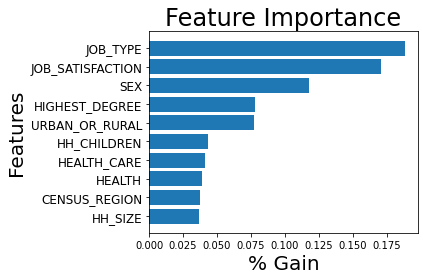

In [589]:
feat_imp = pd.DataFrame(np.transpose(np.array([X_train.columns, xgbc.feature_importances_]))).sort_values(1, ascending = True)

plt.barh(feat_imp.iloc[7::, 0], feat_imp.iloc[7::,1])
plt.xlabel("% Gain", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 12)
plt.title("Feature Importance", fontsize = 24)
plt.tight_layout()
plt.savefig("feat_imp.png")
plt.show()

In [696]:
top = pd.DataFrame(np.transpose(np.array([df.iloc[X_test.index, :]['PUBID'], xgbc.predict_proba(X_test)[:, 1]])), columns=['PUBID', 'JS_PROB'])
top['JOB_SEARCH'] = list(y_test)

In [688]:
top_10 = top.sort_values("JS_PROB", ascending = False).reset_index(drop = True).iloc[:10, :]

In [692]:
import dataframe_image as dfi
dfi.export(top_10, 'top_10.png')

In [701]:
X_test["PUBID"] = df.iloc[X_test.index, :]['PUBID']

In [706]:
top_10["PUBID"]

0    4111.0
1    3800.0
2    1515.0
3    1504.0
4    7944.0
5    1408.0
6    3418.0
7    4709.0
8    3856.0
9    3006.0
Name: PUBID, dtype: float64

In [711]:
X_test[X_test["PUBID"] == 1504]

,SEX,BDATE,RACE/ETHNICITY,CENSUS_REGION,HH_POV_RATIO,HH_SIZE,HIGHEST_DEGREE,HH_CHILDREN,URBAN_OR_RURAL,WRK_SCHEDULE,JOB_SATISFACTION,HEALTH,HEALTH_CARE,CURR_WORKING,EMP_START_M,EMP_START_Y,JOB_TYPE,PUBID
1502,2.0,1983.0,4.0,3.0,2.63,4.0,4.0,2.0,1.0,-999.0,4.0,2.0,1.0,1.0,6.0,2018.0,2.0,1504.0


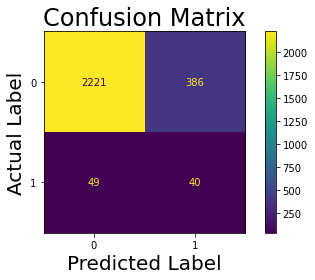

In [593]:
disp = ConfusionMatrixDisplay.from_estimator(xgbc, X_test, y_test)
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('Actual Label', fontsize = 20)
plt.title('Confusion Matrix', fontsize = 24)
plt.savefig("final_conf.png")
plt.tight_layout()
plt.show()

## Notes
* Data results in several things:
1. Focus on tree based algorithms because there is a lot of missing data
2. Potentially lacking several key features (each person is around the same age and this is data from the same year so maybe an individual had already searched for a new job in the last 4 years)
3. Used fbeta with beta = 2 because Recall is much more important than Precision here
-> If I were a recruiter, I wouldn't want to miss the opportunity to contact a person that is searching for a job \
-> Likewise, if I were an employer, I would want to know who is actually at risk of leaving


* Used Decision Tree, Random Forest and XGBoost
* Tuned hyperparameters for each method by trying to maximize a F2 score
* Created pipelines for 5 fold cross validation and handling class imbalance for each validation
* Need to create plots (currently only have confusion matrices)
* Other plots include pie chart of label distribution, tables of scores, and feature importance
* Will not include any ROC curves due to the class imbalance
* Create presentation and write up


* Questions:
* Is the presentation meant to be more technical - about models and the process I went through
* Or more focused on findings


Can always set predict_proba_ \
Limitations on data \
Business context -> Models/technical stuff -> Insights \
Mention parameters that I found for final model (if I have time) \
Show recall over different methods and hyperparameter tuning \
Create a plot for feature importance \
Identify top 10 people that will leave their current job \
Talk about why I chose a F2 metric - expect people to already know what the F beta metric is

In [476]:
ftest = make_scorer(fbeta_score, beta = 100)

def objectiveTest(space):
    clf = xgb.XGBClassifier(eta = space["eta"],
                            n_estimators = space["n_estimators"], 
                            gamma = space["gamma"],
                            max_depth = int(space["max_depth"]),
                            min_child_weight = int(space["min_child_weight"]),
                            max_delta_step = int(space["max_delta_step"]),
                            subsample = space["subsample"],
                            colsample_bytree = space["colsample_bytree"],
                            colsample_bylevel = space["colsample_bylevel"],
                            colsample_bynode = space["colsample_bynode"],
                            reg_alpha = int(space["reg_alpha"]),
                            reg_lambda = space["reg_lambda"],
                            eval_metric='mlogloss',
                            use_label_encoder = False,
                            random_state = 42)
    
    imba_pipeline = make_pipeline(SMOTE(random_state = 42), clf)
    ftest_score = cross_val_score(imba_pipeline, X_train, y_train, scoring = ftest, cv = kf).mean()
    return {"loss": -ftest_score, "status": STATUS_OK}

In [442]:
trials = Trials()
params = fmin(fn = objectiveTest, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

100%|██████████| 100/100 [05:43<00:00,  3.44s/trial, best loss: -0.8394794876419388]


In [443]:
params["use_label_encoder"] = False
params["n_estimators"] = 180
params["max_delta_step"] = int(params["max_delta_step"])
params["max_depth"] = int(params["max_depth"])
params["min_child_weight"] = int(params["min_child_weight"])
params["reg_alpha"] = int(params["reg_alpha"])
params["eval_metric"] = "mlogloss"
params["random_state"] = 42

In [444]:
xgbc = xgb.XGBClassifier(**params)

In [446]:
xgbc.fit(X_train_os, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.30525398555572325,
              colsample_bynode=0.6755993948310463,
              colsample_bytree=0.4205689139815138, enable_categorical=False,
              eta=0.0017767254224281825, eval_metric='mlogloss',
              gamma=1.1362256618169027, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0017767254,
              max_delta_step=48, max_depth=15, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=179, reg_lambda=0.12910067390940383, scale_pos_weight=1,
              subsample=0.23520764304268482, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [448]:
y_pred = pd.Series(xgbc.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"f2: {fbeta_score(y_test, y_pred, beta = 100)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

Accuracy: 0.6172106824925816
Precision: 0.06703397612488522
Recall: 0.8202247191011236
f1: 0.12393887945670629
f2: 0.8193042445816299
AUC: 0.7152523672222151


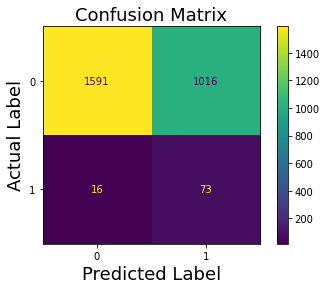

In [465]:
disp = ConfusionMatrixDisplay.from_estimator(xgbc, X_test, y_test)
plt.xlabel('Predicted Label', fontsize = 18)
plt.ylabel('Actual Label', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()